
<div style="text-align:center; font-size:32px;">
XGB_boost Model
</div>

---

### Import necessary librairies

In [50]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,root_mean_squared_error
from xgboost import XGBRegressor

## Data prep
---

In [ ]:
# upload the excel file 
df_excel_complete = pd.read_excel('Proj_B1_consolidado_indicadores_Eloi_version.xlsx')

# convert to CSV so it can be processed in python
df_excel_complete.to_csv('Proj_B1_consolidado_indicadores.csv', index=False)

# Visual check of the conversion
df_excel_complete


,DATE,Bananas,Bananas s/prod22,Proj_Bananas,Proj_Bananas 2,Proj_Bananas_Eloi,Bananas actuel,GDP,Inflation,Unemployment_Rate,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,201907.0,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.7,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201908.0,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.1,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201909.0,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.3,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201910.0,NaN,NaN,NaN,NaN,NaN,NaN,0.80,-0.1,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201911.0,NaN,NaN,NaN,NaN,NaN,NaN,0.80,0.2,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,202609.0,NaN,NaN,0.041669,0.046641,0.056287,0.075658,1.95,2.1,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,202610.0,NaN,NaN,0.041428,0.046066,0.055502,0.075658,1.97,2.5,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,202611.0,NaN,NaN,0.041253,0.045077,0.054870,0.075658,1.97,2.4,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,202612.0,NaN,NaN,0.036705,0.044155,0.054381,0.075658,1.97,2.3,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# columns of the CSV file 
df_excel_complete.columns

Index(['DATE', 'Bananas', 'Bananas s/prod22', 'Proj_Bananas', 'Proj_Bananas 2',
       'Proj_Bananas_Eloi', 'Bananas actuel', 'GDP', 'Inflation',
       'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_RateE3m',
       'Euribor1year', 'Unnamed: 13', 'Unnamed: 14', 'Idmes', 'Quarter',
       'GDP.1', 'Inflation.1', 'Unemployment_Rate.1', 'LT_Interest_Rate.1',
       'ST_Interest_Rate', 'Euribor1year.1', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36'],
      dtype='object')

In [53]:
# Sélections of necessary columns
columns_needed = ['DATE',
                  'Bananas',
                  'GDP',
                  'Inflation',
                  'Unemployment_Rate',
                  'LT_Interest_Rate',
                  'ST_Interest_RateE3m',
                  'Euribor1year']

df_reduced=df_excel_complete[columns_needed]
df_reduced.head()


,DATE,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year
0,201907.0,NaN,0.4,-0.7,6.6,0.44,-0.3649,-0.2833
1,201908.0,NaN,0.4,-0.1,6.5,0.17,-0.4077,-0.3563
2,201909.0,NaN,0.4,-0.3,6.6,0.20,-0.4176,-0.3391
3,201910.0,NaN,0.8,-0.1,6.6,0.19,-0.4129,-0.3042
4,201911.0,NaN,0.8,0.2,6.8,0.35,-0.4013,-0.2720


In [54]:
# Recharger la colonne DATE en string -> enlève le .0 a la fin du numéro de l'année 
df_excel_complete['DATE'] = df_excel_complete['DATE'].astype(str).str.replace('.0', '', regex=False)
df_excel_complete

,DATE,Bananas,Bananas s/prod22,Proj_Bananas,Proj_Bananas 2,Proj_Bananas_Eloi,Bananas actuel,GDP,Inflation,Unemployment_Rate,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,201907,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.7,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201908,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.1,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201909,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.3,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201910,NaN,NaN,NaN,NaN,NaN,NaN,0.80,-0.1,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201911,NaN,NaN,NaN,NaN,NaN,NaN,0.80,0.2,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,202609,NaN,NaN,0.041669,0.046641,0.056287,0.075658,1.95,2.1,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,202610,NaN,NaN,0.041428,0.046066,0.055502,0.075658,1.97,2.5,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,202611,NaN,NaN,0.041253,0.045077,0.054870,0.075658,1.97,2.4,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,202612,NaN,NaN,0.036705,0.044155,0.054381,0.075658,1.97,2.3,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Extraire l'année et le mois (supposons que le format est 'YYYYMM')
df_excel_complete['DATE'] = pd.to_datetime(df_excel_complete['DATE'], format='%Y%m')

# Sélectionner les colonnes nécessaires
columns_needed = ['DATE', 'Bananas', 'GDP', 'Inflation', 'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year']
df_reduced = df_excel_complete[columns_needed]

# Mettre la colonne DATE en index
df_reduced = df_reduced.set_index('DATE')

In [56]:
#on met la date en index du datasest
df_reduced.index = pd.to_datetime(df_reduced.index)
df_reduced.head()

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year
DATE,,,,,,,
2019-07-01,NaN,0.4,-0.7,6.6,0.44,-0.3649,-0.2833
2019-08-01,NaN,0.4,-0.1,6.5,0.17,-0.4077,-0.3563
2019-09-01,NaN,0.4,-0.3,6.6,0.20,-0.4176,-0.3391
2019-10-01,NaN,0.8,-0.1,6.6,0.19,-0.4129,-0.3042
2019-11-01,NaN,0.8,0.2,6.8,0.35,-0.4013,-0.2720


In [57]:
# on supprime la dernière ligne qui est incomplète
df_reduced=df_reduced.iloc[:-1,:]
print(df_reduced.dtypes)

Bananas                float64
GDP                    float64
Inflation               object
Unemployment_Rate      float64
LT_Interest_Rate       float64
ST_Interest_RateE3m     object
Euribor1year           float64
dtype: object


In [58]:
cols_to_convert = ['Inflation', 'ST_Interest_RateE3m']

for col in cols_to_convert:
    df_reduced[col] = pd.to_numeric(df_reduced[col], errors='coerce')

In [59]:
# Filtrer les données connues (jusqu'à juillet 2025 inclus)
df_known = df_reduced.loc[:'2025-07']

# Convertir les colonnes nécessaires en float
cols_to_convert = ['Inflation', 'ST_Interest_RateE3m']

for col in cols_to_convert:
    df_known[col] = pd.to_numeric(df_known[col], errors='coerce')

# Vérifier que tout est bien float maintenant
print(df_known.dtypes)

# Séparation train/test sur les données connues
train_size = int(len(df_known) * 0.8)
train, test = df_known[:train_size], df_known[train_size:]
train = train.dropna()
# Données à prédire (après juillet 2025)
df_forecast = df_reduced.loc['2025-08':]

# Vérification
print(train.shape, test.shape)
print(df_forecast.shape)

Bananas                float64
GDP                    float64
Inflation              float64
Unemployment_Rate      float64
LT_Interest_Rate       float64
ST_Interest_RateE3m    float64
Euribor1year           float64
dtype: object
(46, 7) (15, 7)
(17, 7)


/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_59342/1863211086.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known[col] = pd.to_numeric(df_known[col], errors='coerce')



---


### Feature prep

In [60]:
#definir X et y pour l'entrainement du modele
features = ['GDP', 'Inflation', 'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year']
X_train = train[features]
y_train = train['Bananas']
X_test = test[features]
y_test = test['Bananas']


In [61]:
X_train

,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year
DATE,,,,,,
2020-07-01,14.4,-0.1,8.2,0.40,-0.4441,-0.2789
2020-08-01,14.4,-0.2,8.3,0.36,-0.4797,-0.3589
2020-09-01,14.4,-0.8,8.1,0.32,-0.4914,-0.4146
2020-10-01,0.2,-0.6,7.6,0.18,-0.5091,-0.4660
2020-11-01,0.2,-0.4,7.2,0.07,-0.5209,-0.4806
2020-12-01,0.2,-0.3,6.9,0.03,-0.5381,-0.4966
2021-01-01,-2.8,0.2,7.0,0.03,-0.5472,-0.5047
2021-02-01,-2.8,0.3,7.0,0.16,-0.5411,-0.5009
2021-03-01,-2.8,0.1,6.8,0.23,-0.5391,-0.4867


In [62]:
y_train

DATE
2020-07-01    0.043437
2020-08-01    0.040134
2020-09-01    0.040497
2020-10-01    0.041286
2020-11-01    0.042188
2020-12-01    0.042471
2021-01-01    0.041921
2021-02-01    0.039109
2021-03-01    0.036047
2021-04-01    0.027355
2021-05-01    0.023560
2021-06-01    0.023568
2021-07-01    0.025691
2021-08-01    0.025819
2021-09-01    0.026737
2021-10-01    0.027689
2021-11-01    0.028446
2021-12-01    0.029269
2022-01-01    0.027318
2022-02-01    0.027579
2022-03-01    0.028315
2022-04-01    0.032446
2022-05-01    0.033680
2022-06-01    0.035237
2022-07-01    0.036317
2022-08-01    0.041387
2022-09-01    0.042503
2022-10-01    0.045632
2022-11-01    0.051418
2022-12-01    0.056538
2023-01-01    0.059207
2023-02-01    0.064510
2023-03-01    0.071183
2023-04-01    0.076833
2023-05-01    0.080064
2023-06-01    0.083302
2023-07-01    0.086610
2023-08-01    0.088941
2023-09-01    0.085664
2023-10-01    0.087588
2023-11-01    0.086182
2023-12-01    0.082701
2024-01-01    0.078117
2024-0

In [63]:
print(X_train.dtypes)

GDP                    float64
Inflation              float64
Unemployment_Rate      float64
LT_Interest_Rate       float64
ST_Interest_RateE3m    float64
Euribor1year           float64
dtype: object


## Final version of XGB_boost with K-fold, lags and itératives predictions

---

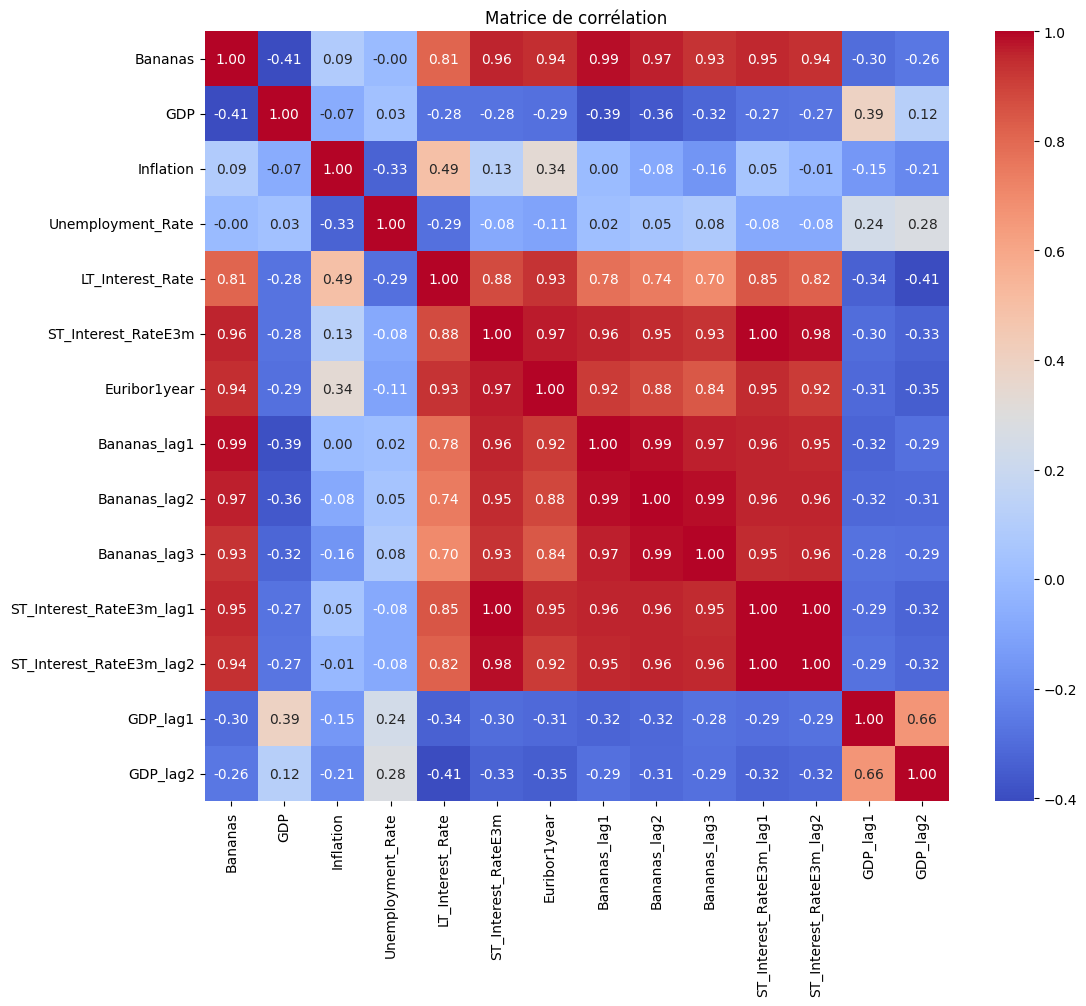

Fold 1 RMSE: 0.00330
Fold 2 RMSE: 0.00429
Fold 3 RMSE: 0.00489
Fold 4 RMSE: 0.00325
Fold 5 RMSE: 0.00256


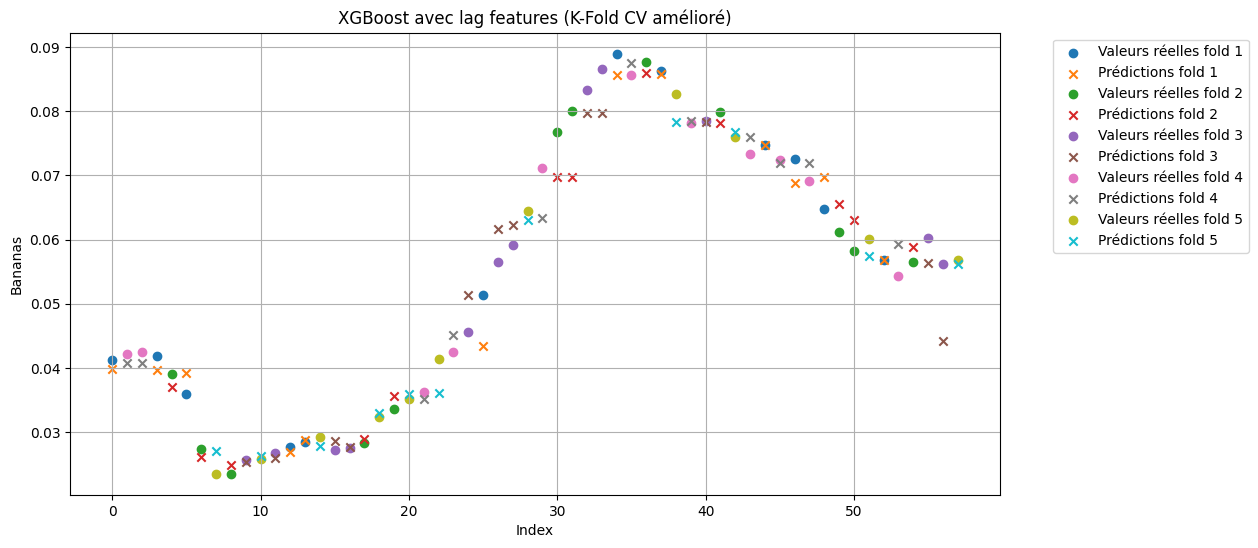

RMSE moyen sur tous les folds: 0.00366


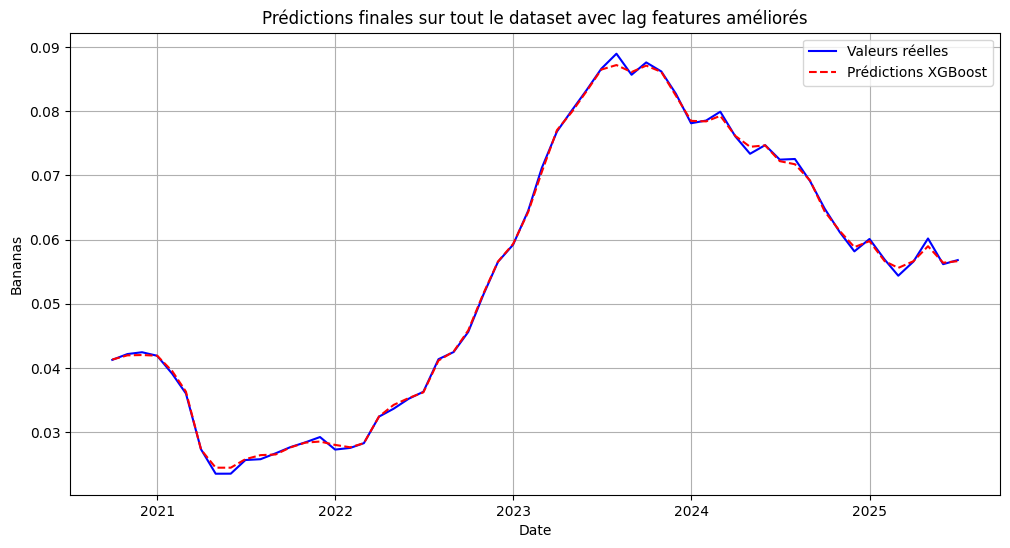

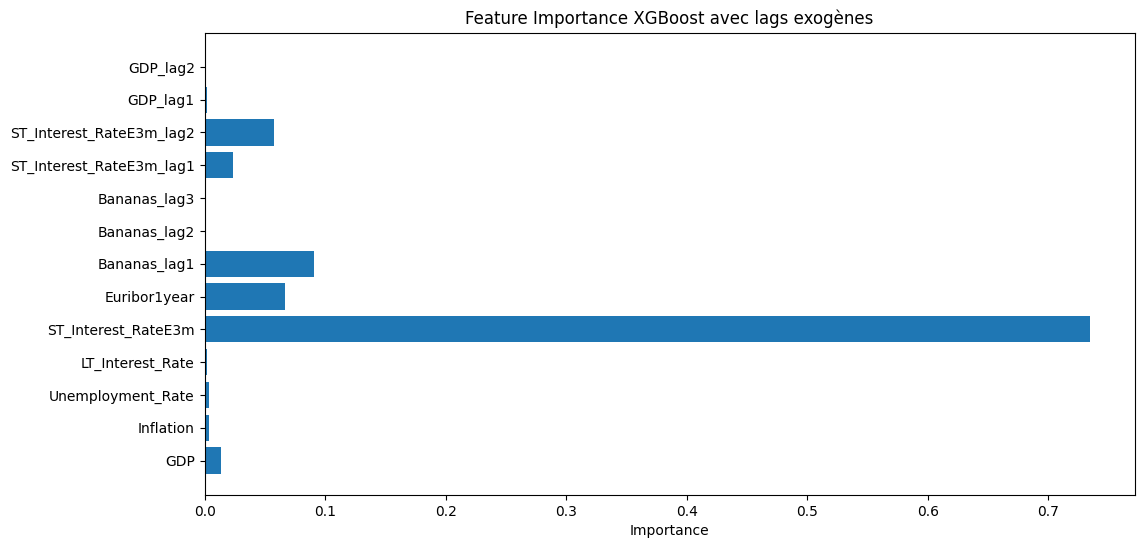

In [64]:
#meilleur modele xgboost avec lag et k fold 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns

# --- 1. Fonction pour créer les lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog={}):
    """
    df : dataframe
    target_col : colonne cible (Bananas)
    lags_target : lags sur la target
    lags_exog : dict {feature_name: [list_of_lags]}
    """
    df_lag = df.copy()
    
    # Lags sur la target
    for lag in lags_target:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    
    # Lags sur les features exogènes
    for feature, lags in lags_exog.items():
        for lag in lags:
            df_lag[f'{feature}_lag{lag}'] = df_lag[feature].shift(lag)
    
    df_lag = df_lag.dropna()
    return df_lag

# Lags
lags_target = [1,2,3]
lags_exog = {
    'ST_Interest_RateE3m': [1,2],
    'GDP': [1,2]
}

df_lag = create_lag_features(df_known, 'Bananas', lags_target=lags_target, lags_exog=lags_exog)

# --- 2. Matrice de corrélation ---
plt.figure(figsize=(12,10))
sns.heatmap(df_lag.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# --- 3. Définir features et target ---
features = ['GDP', 'Inflation', 'Unemployment_Rate', 
            'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year'] + \
           [f'Bananas_lag{lag}' for lag in lags_target] + \
           [f'{feat}_lag{lag}' for feat, lags in lags_exog.items() for lag in lags]

X_all = df_lag[features]
y_all = df_lag['Bananas']

# --- 4. K-Fold Cross-Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

plt.figure(figsize=(12,6))
for i, (train_index, val_index) in enumerate(kf.split(X_all)):
    X_tr, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_tr, y_val = y_all.iloc[train_index], y_all.iloc[val_index]
    
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_tr, y_tr)
    
    y_pred_fold = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_fold))
    rmse_folds.append(rmse)
    
    # Plot des prédictions vs réelles
    plt.scatter(val_index, y_val, label=f'Valeurs réelles fold {i+1}', marker='o')
    plt.scatter(val_index, y_pred_fold, label=f'Prédictions fold {i+1}', marker='x')
    
    print(f"Fold {i+1} RMSE: {rmse:.5f}")

plt.xlabel('Index')
plt.ylabel('Bananas')
plt.title('XGBoost avec lag features (K-Fold CV amélioré)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

print(f"RMSE moyen sur tous les folds: {np.mean(rmse_folds):.5f}")

# --- 5. Entraînement final sur tout le dataset ---
model_final = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model_final.fit(X_all, y_all)

y_pred_all = model_final.predict(X_all)

plt.figure(figsize=(12,6))
plt.plot(df_lag.index, y_all.values, label='Valeurs réelles', color='blue')
plt.plot(df_lag.index, y_pred_all, label='Prédictions XGBoost', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Bananas')
plt.title('Prédictions finales sur tout le dataset avec lag features améliorés')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Feature importance ---
importances = model_final.feature_importances_
plt.figure(figsize=(12,6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance XGBoost avec lags exogènes")
plt.show()


### Code to apply the model for our forecast of 2026

In [65]:
#meilleurs resultats en xgboost et réalisation -> version itérative mais sans k-fold
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Concaténer historique et futur
df_full = pd.concat([df_known, df_forecast])
df_full = df_full.sort_index()

# 2. Créer les lags
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[1]):
    df_lagged = df.copy()
    # Lags de la variable cible
    for lag in lags_target:
        df_lagged[f"{target_col}_lag{lag}"] = df_lagged[target_col].shift(lag)
    # Lags pour les variables exogènes
    for col in df.columns:
        if col != target_col:
            for lag in lags_exog:
                df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

lags_target = [1,2,3]
lags_exog = [1]

df_full_lag = create_lag_features(df_full, "Bananas", lags_target, lags_exog)

# 3. Séparer historique et futur
df_train_lag = df_full_lag.loc[df_full_lag.index].dropna()

X_train = df_train_lag.drop(columns=["Bananas"])
y_train = df_train_lag["Bananas"]

# Entraînement du modèle
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Erreur sur l’historique
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE (train):", rmse_train)

# 4. Prédictions itératives sur le futur
df_future_preds = df_full_lag.loc[df_forecast.index].copy()
features = X_train.columns  # mêmes features qu’au training
y_pred_future = []

for date in df_future_preds.index:
    # Features du mois t
    X_t = df_future_preds.loc[date, features].values.reshape(1, -1)
    # Prédiction Bananas_t
    y_t = model.predict(X_t)[0]
    df_future_preds.loc[date, "Bananas_pred"] = y_t
    y_pred_future.append(y_t)
    
    # Mise à jour des lags pour le mois suivant
    next_idx = df_future_preds.index.get_loc(date) + 1
    if next_idx < len(df_future_preds):
        next_date = df_future_preds.index[next_idx]
        df_future_preds.loc[next_date, "Bananas_lag1"] = y_t
        df_future_preds.loc[next_date, "Bananas_lag2"] = df_future_preds.loc[date, "Bananas_lag1"]
        df_future_preds.loc[next_date, "Bananas_lag3"] = df_future_preds.loc[date, "Bananas_lag2"]

# Résultat final
print("\nPrévisions Bananas 2025-08 → 2026-12 :")
print(df_future_preds[["Bananas_pred"]])
df_future_preds

RMSE (train): 0.0004721205410629262

Prévisions Bananas 2025-08 → 2026-12 :
            Bananas_pred
DATE                    
2025-08-01      0.059866
2025-09-01      0.059370
2025-10-01      0.057417
2025-11-01      0.057417
2025-12-01      0.057417
2026-01-01      0.057108
2026-02-01      0.057341
2026-03-01      0.056785
2026-04-01      0.056247
2026-05-01      0.056247
2026-06-01      0.056785
2026-07-01      0.056974
2026-08-01      0.056785
2026-09-01      0.057341
2026-10-01      0.057341
2026-11-01      0.056247
2026-12-01      0.056415


,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year,Bananas_lag1,Bananas_lag2,Bananas_lag3,GDP_lag1,Inflation_lag1,Unemployment_Rate_lag1,LT_Interest_Rate_lag1,ST_Interest_RateE3m_lag1,Euribor1year_lag1,Bananas_pred
DATE,,,,,,,,,,,,,,,,,
2025-08-01,NaN,1.85,2.319907,6.256436,2.847713,2.673615,1.908,0.056817,0.056180,0.060178,0.60,2.500000,5.900000,3.110000,1.990000,2.080,0.059866
2025-09-01,NaN,1.85,2.319907,6.256436,2.847713,2.673615,1.867,0.059866,0.056817,0.056180,1.85,2.319907,6.256436,2.847713,2.673615,1.908,0.059370
2025-10-01,NaN,1.78,2.218197,6.209587,2.797713,2.423615,1.844,0.059370,0.059866,0.056817,1.85,2.319907,6.256436,2.847713,2.673615,1.867,0.057417
2025-11-01,NaN,1.78,2.218197,6.209587,2.797713,2.423615,1.875,0.057417,0.059370,0.059866,1.78,2.218197,6.209587,2.797713,2.423615,1.844,0.057417
2025-12-01,NaN,1.78,2.218197,6.209587,2.797713,2.423615,1.763,0.057417,0.057417,0.059370,1.78,2.218197,6.209587,2.797713,2.423615,1.875,0.057417
2026-01-01,NaN,1.79,2.200000,6.400000,1.708000,2.320000,2.097,0.057417,0.057417,0.057417,1.78,2.218197,6.209587,2.797713,2.423615,1.763,0.057108
2026-02-01,NaN,1.79,1.900000,6.400000,1.637000,2.100000,1.971,0.057108,0.057417,0.057417,1.79,2.200000,6.400000,1.708000,2.320000,2.097,0.057341
2026-03-01,NaN,1.79,1.800000,6.400000,1.624000,2.200000,1.899,0.057341,0.057108,0.057417,1.79,1.900000,6.400000,1.637000,2.100000,1.971,0.056785
2026-04-01,NaN,1.87,2.100000,6.400000,1.639000,2.020000,1.805,0.056785,0.057341,0.057108,1.79,1.800000,6.400000,1.624000,2.200000,1.899,0.056247


Fold 1 RMSE: 0.0025
Fold 2 RMSE: 0.0042
Fold 3 RMSE: 0.0023
Fold 4 RMSE: 0.0024
Fold 5 RMSE: 0.0026

RMSE moyen (CV): 0.0027660598264947238
RMSE (train complet): 0.0011622943874701457

Prévisions Bananas 2025-08 → 2026-12 :
            Bananas_pred
DATE                    
2025-08-01      0.058373
2025-09-01      0.058386
2025-10-01      0.057570
2025-11-01      0.057499
2025-12-01      0.057461
2026-01-01      0.057456
2026-02-01      0.056915
2026-03-01      0.056976
2026-04-01      0.056740
2026-05-01      0.056727
2026-06-01      0.056883
2026-07-01      0.057008
2026-08-01      0.056713
2026-09-01      0.056114
2026-10-01      0.055773
2026-11-01      0.055601
2026-12-01      0.055738


/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegress

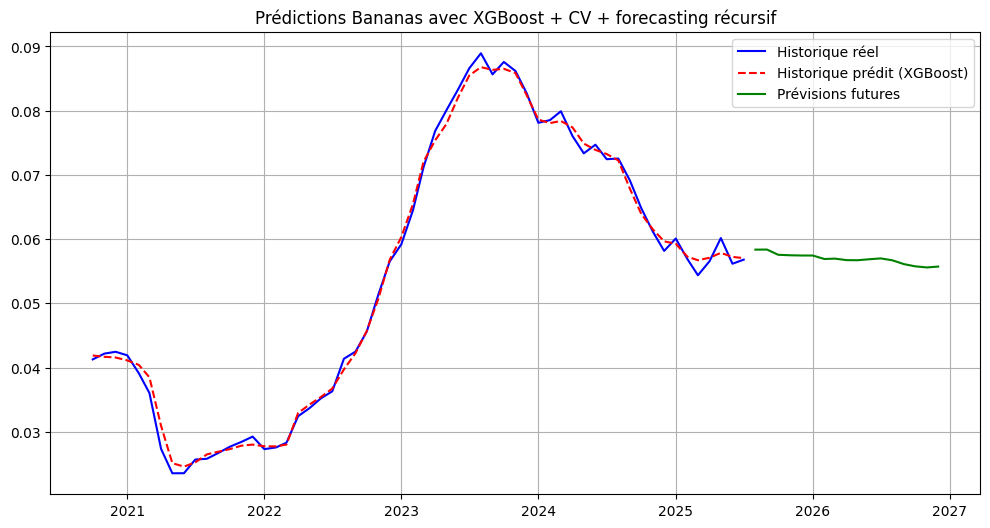

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year,Bananas_lag1,Bananas_lag2,Bananas_lag3,GDP_lag1,Inflation_lag1,Unemployment_Rate_lag1,LT_Interest_Rate_lag1,ST_Interest_RateE3m_lag1,Euribor1year_lag1,Bananas_pred
DATE,,,,,,,,,,,,,,,,,
2025-08-01,NaN,1.85,2.319907,6.256436,2.847713,2.673615,1.908,0.056817,0.056180,0.060178,0.60,2.500000,5.900000,3.110000,1.990000,2.080,0.058373
2025-09-01,NaN,1.85,2.319907,6.256436,2.847713,2.673615,1.867,0.058373,0.056817,0.056180,1.85,2.319907,6.256436,2.847713,2.673615,1.908,0.058386
2025-10-01,NaN,1.78,2.218197,6.209587,2.797713,2.423615,1.844,0.058386,0.058373,0.056817,1.85,2.319907,6.256436,2.847713,2.673615,1.867,0.057570
2025-11-01,NaN,1.78,2.218197,6.209587,2.797713,2.423615,1.875,0.057570,0.058386,0.058373,1.78,2.218197,6.209587,2.797713,2.423615,1.844,0.057499
2025-12-01,NaN,1.78,2.218197,6.209587,2.797713,2.423615,1.763,0.057499,0.057570,0.058386,1.78,2.218197,6.209587,2.797713,2.423615,1.875,0.057461
2026-01-01,NaN,1.79,2.200000,6.400000,1.708000,2.320000,2.097,0.057461,0.057499,0.057570,1.78,2.218197,6.209587,2.797713,2.423615,1.763,0.057456
2026-02-01,NaN,1.79,1.900000,6.400000,1.637000,2.100000,1.971,0.057456,0.057461,0.057499,1.79,2.200000,6.400000,1.708000,2.320000,2.097,0.056915
2026-03-01,NaN,1.79,1.800000,6.400000,1.624000,2.200000,1.899,0.056915,0.057456,0.057461,1.79,1.900000,6.400000,1.637000,2.100000,1.971,0.056976
2026-04-01,NaN,1.87,2.100000,6.400000,1.639000,2.020000,1.805,0.056976,0.056915,0.057456,1.79,1.800000,6.400000,1.624000,2.200000,1.899,0.056740


In [74]:
# --- Imports ---, version avec k-fold cross validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# --- 1. Concaténer historique et futur ---
df_full = pd.concat([df_known, df_forecast])
df_full = df_full.sort_index()

# --- 2. Créer les lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[1]):
    df_lagged = df.copy()
    # Lags de la variable cible
    for lag in lags_target:
        df_lagged[f"{target_col}_lag{lag}"] = df_lagged[target_col].shift(lag)
    # Lags des exogènes
    for col in df.columns:
        if col != target_col:
            for lag in lags_exog:
                df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

lags_target = [1,2,3]
lags_exog = [1]

df_full_lag = create_lag_features(df_full, "Bananas", lags_target, lags_exog)

# --- 3. Séparer historique (train) et futur ---
df_train_lag = df_full_lag.loc[df_known.index].dropna()

X_train = df_train_lag.drop(columns=["Bananas"])
y_train = df_train_lag["Bananas"]

# --- 4. Validation croisée K-Fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model_cv = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=4)  # Modèle XGBoost
    model_cv.fit(X_tr, y_tr)
    
    y_val_pred = model_cv.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_folds.append(rmse)
    print(f"Fold {i+1} RMSE: {rmse:.4f}")

print("\nRMSE moyen (CV):", np.mean(rmse_folds))

# --- 5. Entraînement final sur tout l’historique ---
model_final = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=4)  # Modèle XGBoost
model_final.fit(X_train, y_train)

# Erreur sur train complet
y_train_pred = model_final.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE (train complet):", rmse_train)

# --- 6. Prédictions itératives sur le futur (corrigé) ---
df_future_preds = df_full_lag.loc[df_forecast.index].copy()
features = X_train.columns
y_pred_future = []

# 1️⃣ Initialiser les lags du premier mois du futur avec les dernières valeurs réelles
first_future = df_future_preds.index[0]

df_future_preds.loc[first_future, "Bananas_lag1"] = df_full_lag.loc[df_known.index[-1], "Bananas"]
df_future_preds.loc[first_future, "Bananas_lag2"] = df_full_lag.loc[df_known.index[-2], "Bananas"]
df_future_preds.loc[first_future, "Bananas_lag3"] = df_full_lag.loc[df_known.index[-3], "Bananas"]

# 2️⃣ Boucle récursive pour prédire mois par mois
for date in df_future_preds.index:
    # Features du mois t
    X_t = df_future_preds.loc[date, features].values.reshape(1, -1)
    # Prédiction Bananas_t
    y_t = model_final.predict(X_t)[0]
    df_future_preds.loc[date, "Bananas_pred"] = y_t
    y_pred_future.append(y_t)
    
    # Mise à jour des lags pour le mois suivant
    next_idx = df_future_preds.index.get_loc(date) + 1
    if next_idx < len(df_future_preds):
        next_date = df_future_preds.index[next_idx]
        df_future_preds.loc[next_date, "Bananas_lag1"] = y_t
        df_future_preds.loc[next_date, "Bananas_lag2"] = df_future_preds.loc[date, "Bananas_lag1"]
        df_future_preds.loc[next_date, "Bananas_lag3"] = df_future_preds.loc[date, "Bananas_lag2"]

# --- Résultat final ---
print("\nPrévisions Bananas 2025-08 → 2026-12 :")
print(df_future_preds[["Bananas_pred"]])

# Optionnel : tracé historique vs futur prédit
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_train_lag.index, y_train, label="Historique réel", color="blue")
plt.plot(df_train_lag.index, y_train_pred, label="Historique prédit (XGBoost)", color="red", linestyle="--")
plt.plot(df_future_preds.index, df_future_preds["Bananas_pred"], label="Prévisions futures", color="green")
plt.legend()
plt.grid(True)
plt.title("Prédictions Bananas avec XGBoost + CV + forecasting récursif")
plt.show()
df_future_preds


---

---

## Annexe

In [67]:
from xgboost import XGBRegressor

exog_to_predict = ["Inflation", "ST_Interest_RateE3m", "Unemployment_Rate"]

# Créer les lags de toutes les colonnes sur l'historique
lags_target = [1,2,3]
lags_exog = [1]

def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[1]):
    df_lagged = df.copy()
    # Lags de la target
    for lag in lags_target:
        df_lagged[f"{target_col}_lag{lag}"] = df_lagged[target_col].shift(lag)
    # Lags des exogènes
    for col in df.columns:
        if col != target_col:
            for lag in lags_exog:
                df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

df_lag = create_lag_features(df_known, "Bananas", lags_target, lags_exog)
df_lag = df_lag.dropna()


In [68]:
df_future = df_forecast.copy()

for exog in exog_to_predict:
    # Définir features et target sur l'historique
    X_exog = df_lag.drop(columns=[exog])
    y_exog = df_lag[exog]

    model_exog = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.05, max_depth=3)
    model_exog.fit(X_exog, y_exog)

    # Prédictions mois par mois
    for date in df_future.index:
        # Créer une ligne vide avec les colonnes de X_exog
        X_row = pd.DataFrame(columns=X_exog.columns, index=[0])

        # Remplir les valeurs des lags depuis les dernières lignes connues
        for col in X_exog.columns:
            if col in df_lag.columns:
                X_row[col] = df_lag[col].iloc[-1]
            else:
                X_row[col] = 0  # ou np.nan si tu veux

        # Prédiction
        df_future.loc[date, exog] = model_exog.predict(X_row.values)[0]

        # Ajouter cette ligne au df_lag pour que les lags suivants soient mis à jour
        new_row = X_row.copy()
        new_row[exog] = df_future.loc[date, exog]
        df_lag = pd.concat([df_lag, new_row], ignore_index=True)


In [69]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# --- 1. Fonction pour créer les lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog={}):
    df_lag = df.copy()
    
    # Lags de la variable cible
    for lag in lags_target:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    
    # Lags sur les features exogènes
    for feature, lags in lags_exog.items():
        for lag in lags:
            df_lag[f'{feature}_lag{lag}'] = df_lag[feature].shift(lag)
    
    return df_lag

# --- 2. Préparer les exogènes futurs (Inflation, ST_Interest_RateE3m, Unemployment_Rate) ---
exog_features = ['Inflation', 'ST_Interest_RateE3m', 'Unemployment_Rate']
lags_exog = {feat:[1] for feat in exog_features}  # simple lag 1
lags_target = []

# Créer les lags pour les exogènes sur l'historique
df_known_exog = create_lag_features(df_known, target_col='', lags_target=lags_target, lags_exog=lags_exog)

# Entraîner un modèle par exogène
models_exog = {}
for exog in exog_features:
    X_train = df_known_exog.drop(columns=exog)
    y_train = df_known_exog[exog]
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    models_exog[exog] = model

# Prédire les exogènes futur mois par mois
df_future = df_forecast.copy()
df_lag = df_known_exog.copy()

for date in df_future.index:
    for exog in exog_features:
        X_row = df_lag.iloc[-1].drop(labels=[exog]).values.reshape(1, -1)
        y_pred_exog = models_exog[exog].predict(X_row)[0]
        df_future.loc[date, exog] = y_pred_exog
    
    df_lag = pd.concat([df_lag, df_future.loc[[date]]])
    df_lag = create_lag_features(df_lag, target_col='', lags_target=lags_target, lags_exog=lags_exog)

# --- 3. Créer les lags pour Bananas ---
lags_target = [1,2,3]
lags_exog_bananas = {feat:[1] for feat in ['GDP','Inflation','Unemployment_Rate',
                                           'LT_Interest_Rate','ST_Interest_RateE3m','Euribor1year']}

df_full = pd.concat([df_known, df_future])
df_full_lag = create_lag_features(df_full, target_col='Bananas', lags_target=lags_target, lags_exog=lags_exog_bananas)

# Préparer le training set
df_train = df_full_lag.loc[df_known.index].dropna()
X_all = df_train.drop(columns=['Bananas'])
y_all = df_train['Bananas']

# --- 4. K-Fold Cross-Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_all)):
    X_tr, X_val = X_all.iloc[train_idx], X_all.iloc[val_idx]
    y_tr, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]
    
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_tr, y_tr)
    
    y_pred_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    rmse_folds.append(rmse)
    print(f"Fold {i+1} RMSE: {rmse:.5f}")

print(f"RMSE moyen CV: {np.mean(rmse_folds):.5f}")

# --- 5. Entraînement final sur tout l'historique ---
model_final = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model_final.fit(X_all, y_all)

# --- 6. Prédictions de Bananas sur le futur ---
df_future_lag = df_full_lag.loc[df_future.index].copy()
features_bananas = X_all.columns

for date in df_future_lag.index:
    X_row = df_future_lag.loc[date, features_bananas].values.reshape(1, -1)
    y_pred = model_final.predict(X_row)[0]
    df_future_lag.loc[date, 'Bananas_pred'] = y_pred
    
    # Mise à jour des lags
    for lag in lags_target:
        next_idx = df_future_lag.index.get_loc(date) + lag
        if next_idx < len(df_future_lag):
            next_date = df_future_lag.index[next_idx]
            df_future_lag.loc[next_date, f'Bananas_lag{lag}'] = y_pred

# --- 7. Résultat final ---
print(df_future_lag[['Bananas_pred']])


Fold 1 RMSE: 0.00314
Fold 2 RMSE: 0.00379
Fold 3 RMSE: 0.00489
Fold 4 RMSE: 0.00292
Fold 5 RMSE: 0.00266
RMSE moyen CV: 0.00348
            Bananas_pred
DATE                    
2025-08-01      0.044184
2025-09-01      0.038299
2025-10-01      0.034352
2025-11-01      0.029564
2025-12-01      0.029508
2026-01-01      0.029199
2026-02-01      0.029199
2026-03-01      0.029199
2026-04-01      0.029199
2026-05-01      0.029199
2026-06-01      0.029199
2026-07-01      0.029199
2026-08-01      0.029199
2026-09-01      0.029199
2026-10-01      0.029199
2026-11-01      0.029199
2026-12-01      0.029368


In [70]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# --- 1. Création des lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[]):
    df_lag = df.copy()
    
    # Lags de la target
    for lag in lags_target:
        df_lag[f"{target_col}_lag{lag}"] = df_lag[target_col].shift(lag)
    
    # Lags des variables exogènes
    for col in lags_exog:
        for lag in [1]:  # tu peux adapter si besoin
            df_lag[f"{col}_lag{lag}"] = df_lag[col].shift(lag)
    
    return df_lag

lags_target = [1,2,3]
exog_features = ['GDP','Inflation','Unemployment_Rate','LT_Interest_Rate',
                 'ST_Interest_RateE3m','Euribor1year']

# Concaténer historique + futur pour créer les lags
df_full = pd.concat([df_known, df_forecast]).sort_index()
df_full_lag = create_lag_features(df_full, 'Bananas', lags_target, exog_features)

# --- 2. Séparer training (historique) ---
df_train = df_full_lag.loc[df_known.index].dropna()
X_train = df_train.drop(columns=['Bananas'])
y_train = df_train['Bananas']

# --- 3. K-Fold Cross Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_tr, y_tr)
    
    y_pred_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    rmse_folds.append(rmse)
    print(f"Fold {i+1} RMSE: {rmse:.5f}")

print(f"RMSE moyen CV: {np.mean(rmse_folds):.5f}")

# --- 4. Entraînement final sur tout le dataset ---
model_final = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model_final.fit(X_train, y_train)

# --- 5. Prédiction itérative sur le futur ---
df_future = df_full_lag.loc[df_forecast.index].copy()
y_pred_future = []

for date in df_future.index:
    # On prend les features disponibles
    features = X_train.columns
    X_row = df_future.loc[date, features].copy()
    
    # Prédiction
    y_t = model_final.predict(X_row.values.reshape(1, -1))[0]
    df_future.loc[date, 'Bananas_pred'] = y_t
    y_pred_future.append(y_t)
    
    # Mise à jour des lags pour le mois suivant
    next_idx = df_future.index.get_loc(date) + 1
    if next_idx < len(df_future):
        next_date = df_future.index[next_idx]
        for i, lag in enumerate(lags_target):
            df_future.loc[next_date, f'Bananas_lag{lag}'] = (
                df_future.loc[date, f'Bananas_lag{lag-1}'] if lag > 1 else y_t
            )

# --- 6. Résultat final ---
print(df_future[['Bananas_pred']])


Fold 1 RMSE: 0.00314
Fold 2 RMSE: 0.00379
Fold 3 RMSE: 0.00489
Fold 4 RMSE: 0.00292
Fold 5 RMSE: 0.00266
RMSE moyen CV: 0.00348
            Bananas_pred
DATE                    
2025-08-01      0.059866
2025-09-01      0.059370
2025-10-01      0.057417
2025-11-01      0.057417
2025-12-01      0.057417
2026-01-01      0.057108
2026-02-01      0.057341
2026-03-01      0.056785
2026-04-01      0.056247
2026-05-01      0.056247
2026-06-01      0.056785
2026-07-01      0.056974
2026-08-01      0.056785
2026-09-01      0.057341
2026-10-01      0.057341
2026-11-01      0.056247
2026-12-01      0.056415
